# Lab 3 Report

Prepared by Zech Wolf

## 1. Preparation and overview

### 1.1 Business understanding

In school, math is a very important subject. It is relevant to many disciplines and is also useful in everyday life. Math is also a difficult subject that many students struggle with at all levels. Thus, it could be of interest to educators, who are driven to help their students succeed, to be able to predict which students are struggling before a math test, and take steps to make sure they get the help they need. For instance, if a student is projected to fail a test, a teacher could take care to focus on that student's understanding during class, refer them to extra tutoring sessions, or let the parents know that their student is having trouble. An educator might also use this prediction to get an idea of how their class as a whole is expected to perform, and use the information to adjust their teaching style and pace.

The dataset I chose contains student test scores for writing, reading, and math. Each student has a row in the dataset with their scores, some demographic information, and whether or not they took a test prep course. The classification task is extracted from the math score, which I categorize as failing (<70%), passing (70-83%), or exceptional (>83%, B and above). These are three categories that would be of interest for an educator. The failing category is important to identify so a teacher can focus on these students more to help prepare them better. The passing category would represent students who are doing fine and will most likely pass the class, but could be encouraged to put in a little more effort to reach their full potential. Finally, students in the exceptional category might be encouraged to investigate more advanced topics, to keep them engaged in a class that might be on the easier side for them.

In terms of performance, it is important to look at the true positive rate. False negatives, especially in the failing category, need to be minimized, as this would result in students who really are struggling, falling through the cracks and not getting the support they need. In general, it would be problematic if a student is predicted to perform better on the test than they actually will. It is not as problematic if a student is predicted to do worse than they actually will, as extra support could be beneficial for any student. Thus, recall is an important metric to consider for judging the performance of the model. However, optimizing for recall typically comes at the cost of precision, so in order to avoid sacrificing too much precision, I will use the harmonic mean of precision and recall - F1 score - to evaluate the performance of the model.

Dataset source: https://www.kaggle.com/datasets/whenamancodes/students-performance-in-exams

### 1.2 Data description

The dataset contains 1000 instances with 8 features. The features in the dataset and how I will process and encode them is summarized in the table

| Feature | Description | Data type/representation |
| --- | --- | --- |
| Gender | male or female | binary |
| Race/ethnicity | generically named ethnic category (group A,B...) | one hot encoding |
| Parental level of education | highest education achieved by a parent (highschool, some college...) | int [1,6] |
| Lunch | does the student get free or reduced lunch? | binary |
| Test preparation course | did the student take the test prep course? | binary |
| Reading score | test score | int [0,100] -> z-score |
| Writing score | test score | int [0,100] -> z-score |
| Math score | test score | Target {0: failing, 1: passing, 2: exceptional} |

### 1.3 Data preprocessing

There are four steps to prepare this dataset for classification with logistic regression
* Discretize math score as "failing", "passing", or "exceptional" (0,1,2)
* One hot encode the categorical features (this is done using $k-1$ dummies to reduce the number of features)
* Encode parent education as ordinal value from 1 to 6
* Standardize writing and reading test grades as z-scores

In [36]:
import pandas as pd

#Read in dataframe
df = pd.read_csv("datasets/exams.csv")

In [18]:
import numpy as np

#Encode parental education as an ordinal feature
def encode_ed(edlevel: str):
    ordering = {"some high school": 1, "high school": 2, "some college": 3,
                "associate's degree": 4, "bachelor's degree": 5, "master's degree": 6}

    return ordering[edlevel]

encode_ed = np.vectorize(encode_ed)
df["parent_ed"] = encode_ed(df["parental level of education"])

#Create target variable from math score
def encode_score(score: int):
    if score < 70: #failing
        return 0
    elif score >= 70 and score < 83: #passing
        return 1
    else: #exceptional
        return 2

encode_score = np.vectorize(encode_score)
df["math_score"] = encode_score(df["math score"])

#One hot encoding for the remaining nominal features
df = pd.get_dummies(data=df, columns=["gender", "race/ethnicity", "lunch", "test preparation course"], drop_first=True)

#Remove original unprocessed columns
df.drop(columns=["parental level of education", "math score"], inplace=True) #drop old education column

#Normalize numeric columns
from sklearn.preprocessing import StandardScaler

df[["writing score", "reading score"]] = StandardScaler().fit_transform(df[["writing score", "reading score"]])

In [19]:
#Save the processed data to a pickle file to read in later
df.info()
df.to_pickle("datasets/exams_processed.pkl")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   reading score                 1000 non-null   float64
 1   writing score                 1000 non-null   float64
 2   parent_ed                     1000 non-null   int64  
 3   math_score                    1000 non-null   int64  
 4   gender_male                   1000 non-null   uint8  
 5   race/ethnicity_group B        1000 non-null   uint8  
 6   race/ethnicity_group C        1000 non-null   uint8  
 7   race/ethnicity_group D        1000 non-null   uint8  
 8   race/ethnicity_group E        1000 non-null   uint8  
 9   lunch_standard                1000 non-null   uint8  
 10  test preparation course_none  1000 non-null   uint8  
dtypes: float64(2), int64(2), uint8(7)
memory usage: 38.2 KB


### 1.4 Train-test split

In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

READ_DF = True

#Read in the preprocessed dataframe if specified
if READ_DF:
    df = pd.read_pickle("datasets/exams_processed.pkl")

#Get X and y arrays from df
X = df.drop(columns=["math_score"]).to_numpy()
y = df["math_score"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y) #80/20 split

In [4]:
#Check on the class balance in each set
print("y: ", np.unique(y, return_counts=True))
print("y_train: ", np.unique(y_train, return_counts=True))
print("y_test: ", np.unique(y_test, return_counts=True))

y:  (array([0, 1, 2]), array([566, 273, 161]))
y_train:  (array([0, 1, 2]), array([453, 218, 129]))
y_test:  (array([0, 1, 2]), array([113,  55,  32]))


80/20 is probably not a good split for this dataset. There are only 1000 samples in the dataset, and the classes are highly imbalanced, with the "exceptional" class only having 161 instances. This results in a testing set with only 32 "exceptional" instances. There is a high chance that the sampling of this class may not be representative of the population, so it is reasonable to be skeptical of the model's performance on the testing set, and how well it would generalize to work with unseen data points. Both the "passing" and "exceptional" classes are relatively low in number in both the training and test set. It is possible that the number of instances in the training set may not be enough for the classifier to train on to recognize these classes accurately. A better approach might be to repeat the 80/20 split several times over with random variation, in order to get a better perspective on the model's generalized performance.

## 2. Modeling

### 2.1 Implementation

In [50]:
#The general template used here is taken and adpated from several different parts of the example notebook
import numpy as np
from scipy.special import expit

class BinaryLogisticRegression:
    """
    This is the underlying class used for one-versus-all in the main logistic regression
    """
    def __init__(self, penalty="l2", solver="sa", C=1.0, eta=0.1, iterations=20):
        self.eta = eta
        self.iters = iterations
        self.solver = solver
        self.penalty = penalty
        self.C = C #store all the hyperparameters for use later
    
    def __str__(self):
        return 'Base Binary Logistic Regression Object, Not Trainable'
    
    # convenience, private and static:
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    @staticmethod
    def _add_intercept(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term

    @staticmethod
    def _get_ddw_regularization(w, penalty, C):
        """Return the first derivative of the regularization term"""

        regterm = 0
        if penalty == "l1":
            regterm = C * np.sign(w[1:]) #use the sign function to get the derivative of |w|
        
        elif penalty == "l2":
            regterm = C * 2*w[1:]

        elif penalty == "elasticnet": #combine l1 and l2 terms
            C1 = C
            C2 = C

            if type(C) == tuple: #get individual C terms
                C1 = C[0]
                C2 = C[1]

            regterm = (C1 * np.sign(w[1:])) + (C2 * 2*w[1:])

        else: #none - don't apply regularization
            pass

        return regterm

    def _get_gradient(self, X, y):
        """
        Calculate the gradient according to solver and penalty type
        """
        #Make initial calculation using given solver
        gradient = None
        
        ### STEEPEST ASCENT ###
        if self.solver == "sa":
            ydiff = y - self.predict_proba(X,add_intercept=False).ravel() # get y difference
            gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
            gradient = gradient.reshape(self.w_.shape)

        ### STOCHASTIC GRADIENT ASCENT ###
        elif self.solver == "sga":
            idx = np.random.randint(0, len(y)) #index of random instance of X
            ydiff = y[idx] - self.predict_proba(X[idx], add_intercept=False) #calculate ydiff for the random instance of X
            gradient = X[idx] * ydiff[:,np.newaxis] #approximation of gradient using random instance of X
            gradient = gradient.reshape(self.w_.shape)

        ### NEWTON'S METHOD ###
        elif self.solver == "newton":
            g = self.predict_proba(X,add_intercept=False).ravel() # get sigmoid value for all classes

            #Calculate the 2nd derivative of the regularization term for use in the Hessian
            h_reg = 0
            if self.penalty == "l1" or self.penalty == "none": #just being explicit here, l1 has no effect on hessian
                h_reg = 0 #2nd derivative of C*|w| = 0
            elif self.penalty == "l2" or self.penalty == "elasticnet":
                C2 = self.C[1] if type(self.C) == tuple else self.C
                h_reg = 2 * C2
            
            hessian = X.T @ np.diag(g*(1-g)) @ X - h_reg # calculate the hessian with appropriate regularization term

            ydiff = y - g # get y difference
            gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
            gradient = gradient.reshape(self.w_.shape)
            gradient[1:] -= self._get_ddw_regularization(self.w_, self.penalty, self.C)

            #Apply regularization to the gradient before multiplying with inverse of the Hessian
            return np.linalg.pinv(hessian) @ gradient

        ### EXECPTIONAL WORK - NEWTON'S METHOD USING MSE ###
        elif self.solver == "newton-mse":
            #This is a gradient descent problem so some values are inverted to minimize rather than maximize
            g = self.predict_proba(X, add_intercept=False).ravel()

            #Calculate the 2nd derivative of the regularization term for use in the Hessian
            h_reg = 0
            if self.penalty == "l1" or self.penalty == "none": #just being explicit here, l1 has no effect on hessian
                h_reg = 0 #2nd derivative of C*|w| = 0
            elif self.penalty == "l2" or self.penalty == "elasticnet":
                C2 = self.C[1] if type(self.C) == tuple else self.C
                h_reg = 2 * C2

            hessian = -(X.T @ np.diag(3*(g**3) - 2*g*(y + 1) + y) @ X + h_reg) #use -1 * hessian to do gradient descent instead of ascent

            ydiff = y - g
            gradient = -1 * -2*np.sum((ydiff * g * (1 - g))[:,np.newaxis] * X, axis=0) #invert the gradient since we need to minimize mse
            gradient = gradient.reshape(self.w_.shape)
            gradient[1:] += self._get_ddw_regularization(self.w_, self.penalty, self.C)

            return np.linalg.pinv(hessian) @ gradient

        #Apply regularization
        gradient[1:] -= self._get_ddw_regularization(self.w_, self.penalty, self.C)

        return gradient #final result
    
    def fit(self, X, y):
        Xb = self._add_intercept(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate

    def predict_proba(self, X, add_intercept=True):
        # add bias term if requested
        Xb = self._add_intercept(X) if add_intercept else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction

class LogisticRegression:
    def __init__(self, penalty="l2", solver="sa", C=1.0, eta=0.1, iterations=20):
        """
        Construct a multi-class logistic regression classifier.
        This class implements one-versus-all classification using BinaryLogisticRegression classifiers.

        Parameters:
        -----------
        penalty : regularization strategy as one of {"none", "l1", "l2", "elasticnet"}  *elasticnet is both l1 and l2
        solver : optimization strategy as one of {"sa", "sga", "newton", "newton-mse"}
        C : regularization cost (ignored if penalty = "none"). If using penalty="elasticnet", C can be a 2-tuple containing
        the C values for each regularization term (a single float input will be interpreted as use the same C for both terms)
        eta : gradient step amount when updating weights
        iterations : number of iterations before stopping
        """
        self.eta = eta
        self.iters = iterations
        self.solver = solver
        self.penalty = penalty
        self.C = C
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # if we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = (y==yval) # create a binary problem
            # train the binary classifier for this class
            blr = BinaryLogisticRegression(self.penalty, self.solver, self.C, self.eta, self.iters)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return self.unique_[np.argmax(self.predict_proba(X),axis=1)] # take argmax along row

### 2.2 Model tuning

The model's parameters are tuned to produce the best F1 score.

In [16]:
from itertools import product
from sklearn.metrics import f1_score
import pandas as pd

solvers = ["sa", "sga", "newton", "newton-mse"]
penalties = ["none", "l1", "l2", "elasticnet"]
C = [0.001, 0.01, 0.1]

parameters = product(penalties, solvers, C)

df = pd.DataFrame(columns=["penalty", "solver", "C", "f1_score"])
for p in parameters:
    iters = 200 if p[1] in ["newton", "newton-mse"] else 10000 #these turned out to be good values during intial testing
    lr = LogisticRegression(penalty=p[0], solver=p[1], C=p[2], iterations=iters)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    row = pd.DataFrame({"penalty": [p[0]], "solver": [p[1]], "C": [p[2]], "f1_score": [f1_score(y_test, y_pred, average="weighted")]})
    df = pd.concat([df, row])

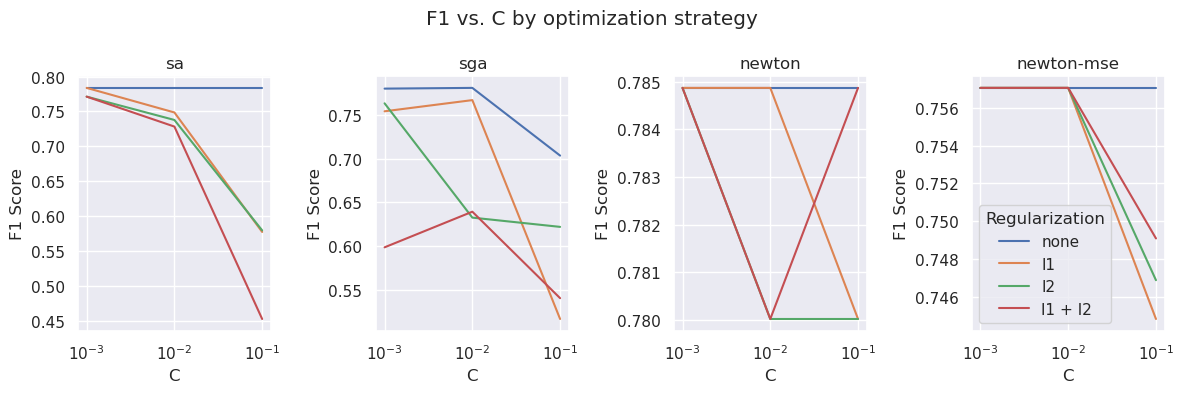

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
plt.figure(figsize=(12,4))
plt.suptitle("F1 vs. C by optimization strategy")
for i,s in enumerate(solvers):
    plt.subplot(1,4,i+1)
    for p in penalties:
        data = df[(df.solver == s) & (df.penalty == p)]
        plt.plot(data.C, data.f1_score)

    plt.title(s)
    plt.xlabel("C")
    plt.ylabel("F1 Score")
    plt.xscale("log")
    plt.tight_layout()

plt.legend(["none", "l1", "l2", "l1 + l2"], title="Regularization")
plt.show()

A few observations:

For all solvers, l1+l2 regularization tends to be the worst peforming penalty. Lower values of C also tend to work better for all models. The best performance is similar across all models, but it looks like Newton's method is a little bit better than the rest.

#### Results sorted by F1 score

In [52]:
df.sort_values(by="f1_score", ascending=False)

,penalty,solver,C,f1_score
0,l1,newton,0.001,0.784874
0,elasticnet,newton,0.001,0.784874
0,l2,newton,0.001,0.784874
0,elasticnet,newton,0.100,0.784874
0,none,newton,0.001,0.784874
0,none,newton,0.010,0.784874
0,none,newton,0.100,0.784874
0,l1,newton,0.010,0.784874
0,none,sa,0.010,0.783755
0,l1,sa,0.001,0.783755


#### Data snooping

Data snooping is definitely an issue for this method of selecting parameters. The test set is not very large (200 instances), and all 48 models were trained once on the same training set. Without any variation in the training and testing sets, the parameters are chosen to optimize the performance specifically with this data, and the best performance achieved in this process is probably not representative of the generalized performance on the model on unseen data.

### 2.3 Comparison with scikit-learn

#### Tuning iterations

My model is not currently designed to stop iterating after convergence is detected. So before comparing with sklearn, I find how many iterations it takes to converge for the best model, to use during the comparison.

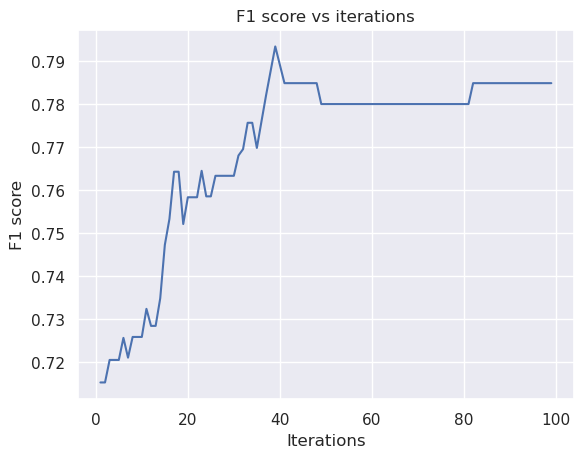

In [36]:
iters = list()
f1s = list()
for i in range(1,100):
    lr = LogisticRegression(penalty="elasticnet", solver="newton", C=.001, iterations=i) #best parameters
    lr.fit(X_train, y_train)
    yhat = lr.predict(X_test)
    iters.append(i)
    f1s.append(f1_score(y_test, yhat, average="weighted"))

plt.plot(iters, f1s)
plt.xlabel("Iterations")
plt.ylabel("F1 score")
plt.title("F1 score vs iterations")
plt.show()

It looks like the model is reaching its peak performance after about 40 iterations. This should be enough to achieve a good performance in both time and classification.

The best performing model by a very small margin is Newton's method (MLE). Based on the results of the tuning, I will use the following parameters to compare with scikit-learn:

* Penalty: l1 + l2 (elasticnet)
* Solver: Newton
* C: 0.01
* Iterations: 40

In [42]:
from sklearn.linear_model import LogisticRegression as SKLR
import time

#Compare training times
lr = LogisticRegression(penalty="elasticnet", solver="newton", C=.001, iterations=40)

lr_avg_time = 0
for _ in range(3):
    t0 = time.time()
    lr.fit(X_train, y_train)
    t1 = time.time()
    lr_avg_time += (t1 - t0)


sklr = SKLR(penalty="l2", solver="newton-cg", C=1/.001, max_iter=40) #most comparable parameters in sklearn

sklr_avg_time = 0
for _ in range(3):
    t0 = time.time()
    sklr.fit(X_train, y_train)
    t1 = time.time()
    sklr_avg_time += (t1 - t0)

lr_avg_time /= 3
sklr_avg_time /= 3

In [43]:
#Compare classification performance
from sklearn.metrics import confusion_matrix

y_pred_lr = lr.predict(X_test)
y_pred_sklr = sklr.predict(X_test)

lr_score = f1_score(y_test, y_pred_lr, average="weighted")
sklr_score = f1_score(y_test, y_pred_sklr, average="weighted")

lr_cm = confusion_matrix(y_test, y_pred_lr)
sklr_cm = confusion_matrix(y_test, y_pred_sklr)

#### Performance visualizations

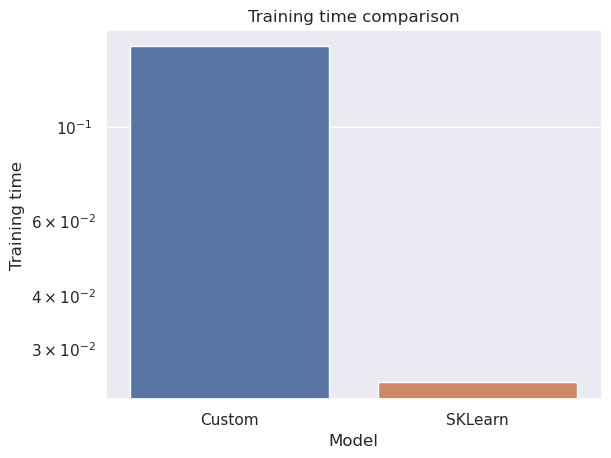

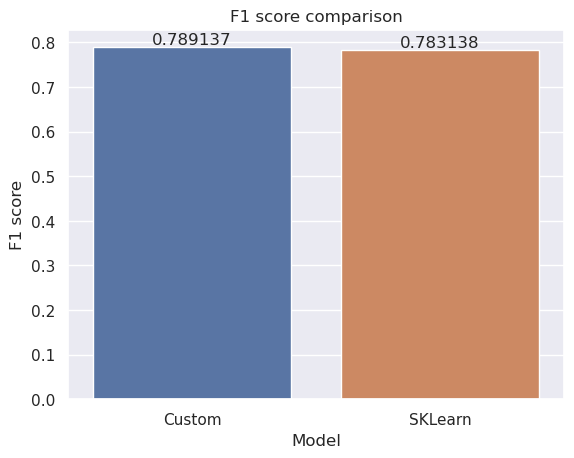

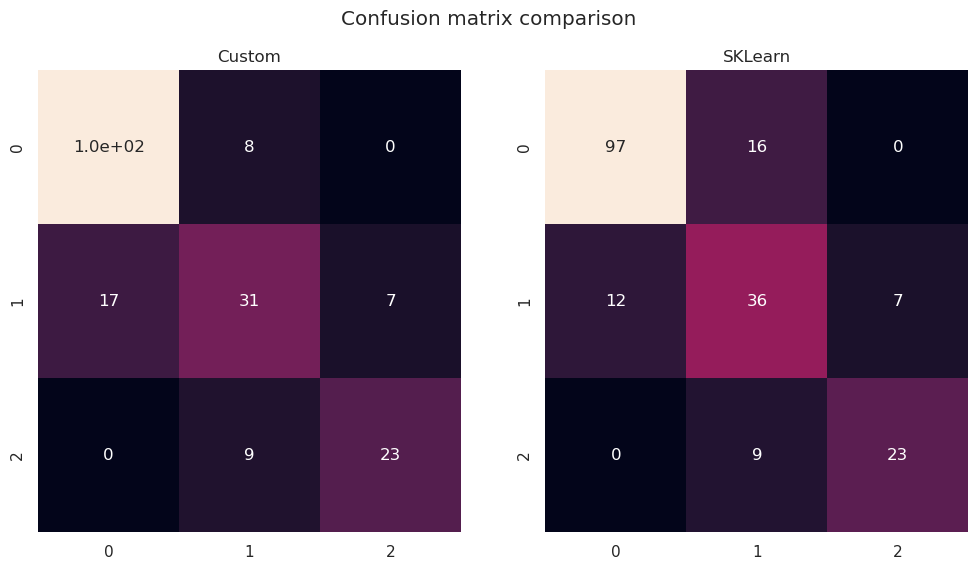

In [49]:
#Training time comparison
sns.barplot(x=["Custom", "SKLearn"], y=[lr_avg_time, sklr_avg_time])
plt.yscale("log")
plt.xlabel("Model")
plt.ylabel("Training time")
plt.title("Training time comparison")
plt.show()

#F1 comparison
ax = sns.barplot(x=["Custom", "SKLearn"], y=[lr_score, sklr_score], )
plt.xlabel("Model")
plt.ylabel("F1 score")
plt.title("F1 score comparison")
for i in ax.containers: ax.bar_label(i)
plt.show()

#Confusion matrix comparison
plt.figure(figsize=(12,6))
plt.suptitle("Confusion matrix comparison")
plt.subplot(1,2,1)
sns.heatmap(lr_cm, annot=True, cbar=False)
plt.title("Custom")

plt.subplot(1,2,2)
sns.heatmap(sklr_cm, annot=True, cbar=False)
plt.title("SKLearn")
plt.show()

#### Results

In terms of training time, sklearn far outperforms my model by an order of magnitude. This difference could be because of optimizations to Newton's method taking place under the hood. For comparison, I chose the most comparable solver in sklearn, "newton-cg," which is somewhat different to the method I used in my implementation. Newton-cg uses a conjugate gradient technique in its optimization, which could provide an upper hand in the training time.

For classification performance, my custom implementation achieves a slightly higher f1 score. The difference (on the order of $10^{-3}$) may seem negligible at first, but the confusion matrices show a difference that is potentially important for the business case. Looking at class 0 (failing), sklearn predicts double the number of false negatives as my model. This means that in the sklearn model, 16 students who failed the test were incorrectly predicted to have passed the test, compared to 8 in my model. In a real-time deployment of the model, where the students are yet to take the math test, this could result in more students not getting the appropriate support they need to succeed.

## 3. Deployment

Based on the results of the comparison, it is difficult to say which model would be better to deploy for use in the business case. Sklearn's superior training time is definitely significant, but it may not be that important to educators. Even in a worst-case scenario, where the training set consists of thousands of student records, training could not take longer than a few seconds for my model, and educators may not care if training takes 10 seconds versus 1 second, or even (assuming my model trains much slower than observered here for some unforeseen reason) several minutes versus a few seconds.

Due to the data snooping in the process performed here, it is difficult to know if my model would continue to perform better in terms of F1 score, on completely new data in a deployment scenario. Assuming that it would, it would make more sense to use my model in deployment, due to the lower number of false negatives in class 0, as this would definitely and measurably affect how useful the model is for educators.

## 4. Exceptional work

### 4.1 Mean squared error logistic regression

In order to use mean squared error with Newton's method, the first and second derivatives of the mean squared error function with respect to $w$ are needed. They are derived as follows:

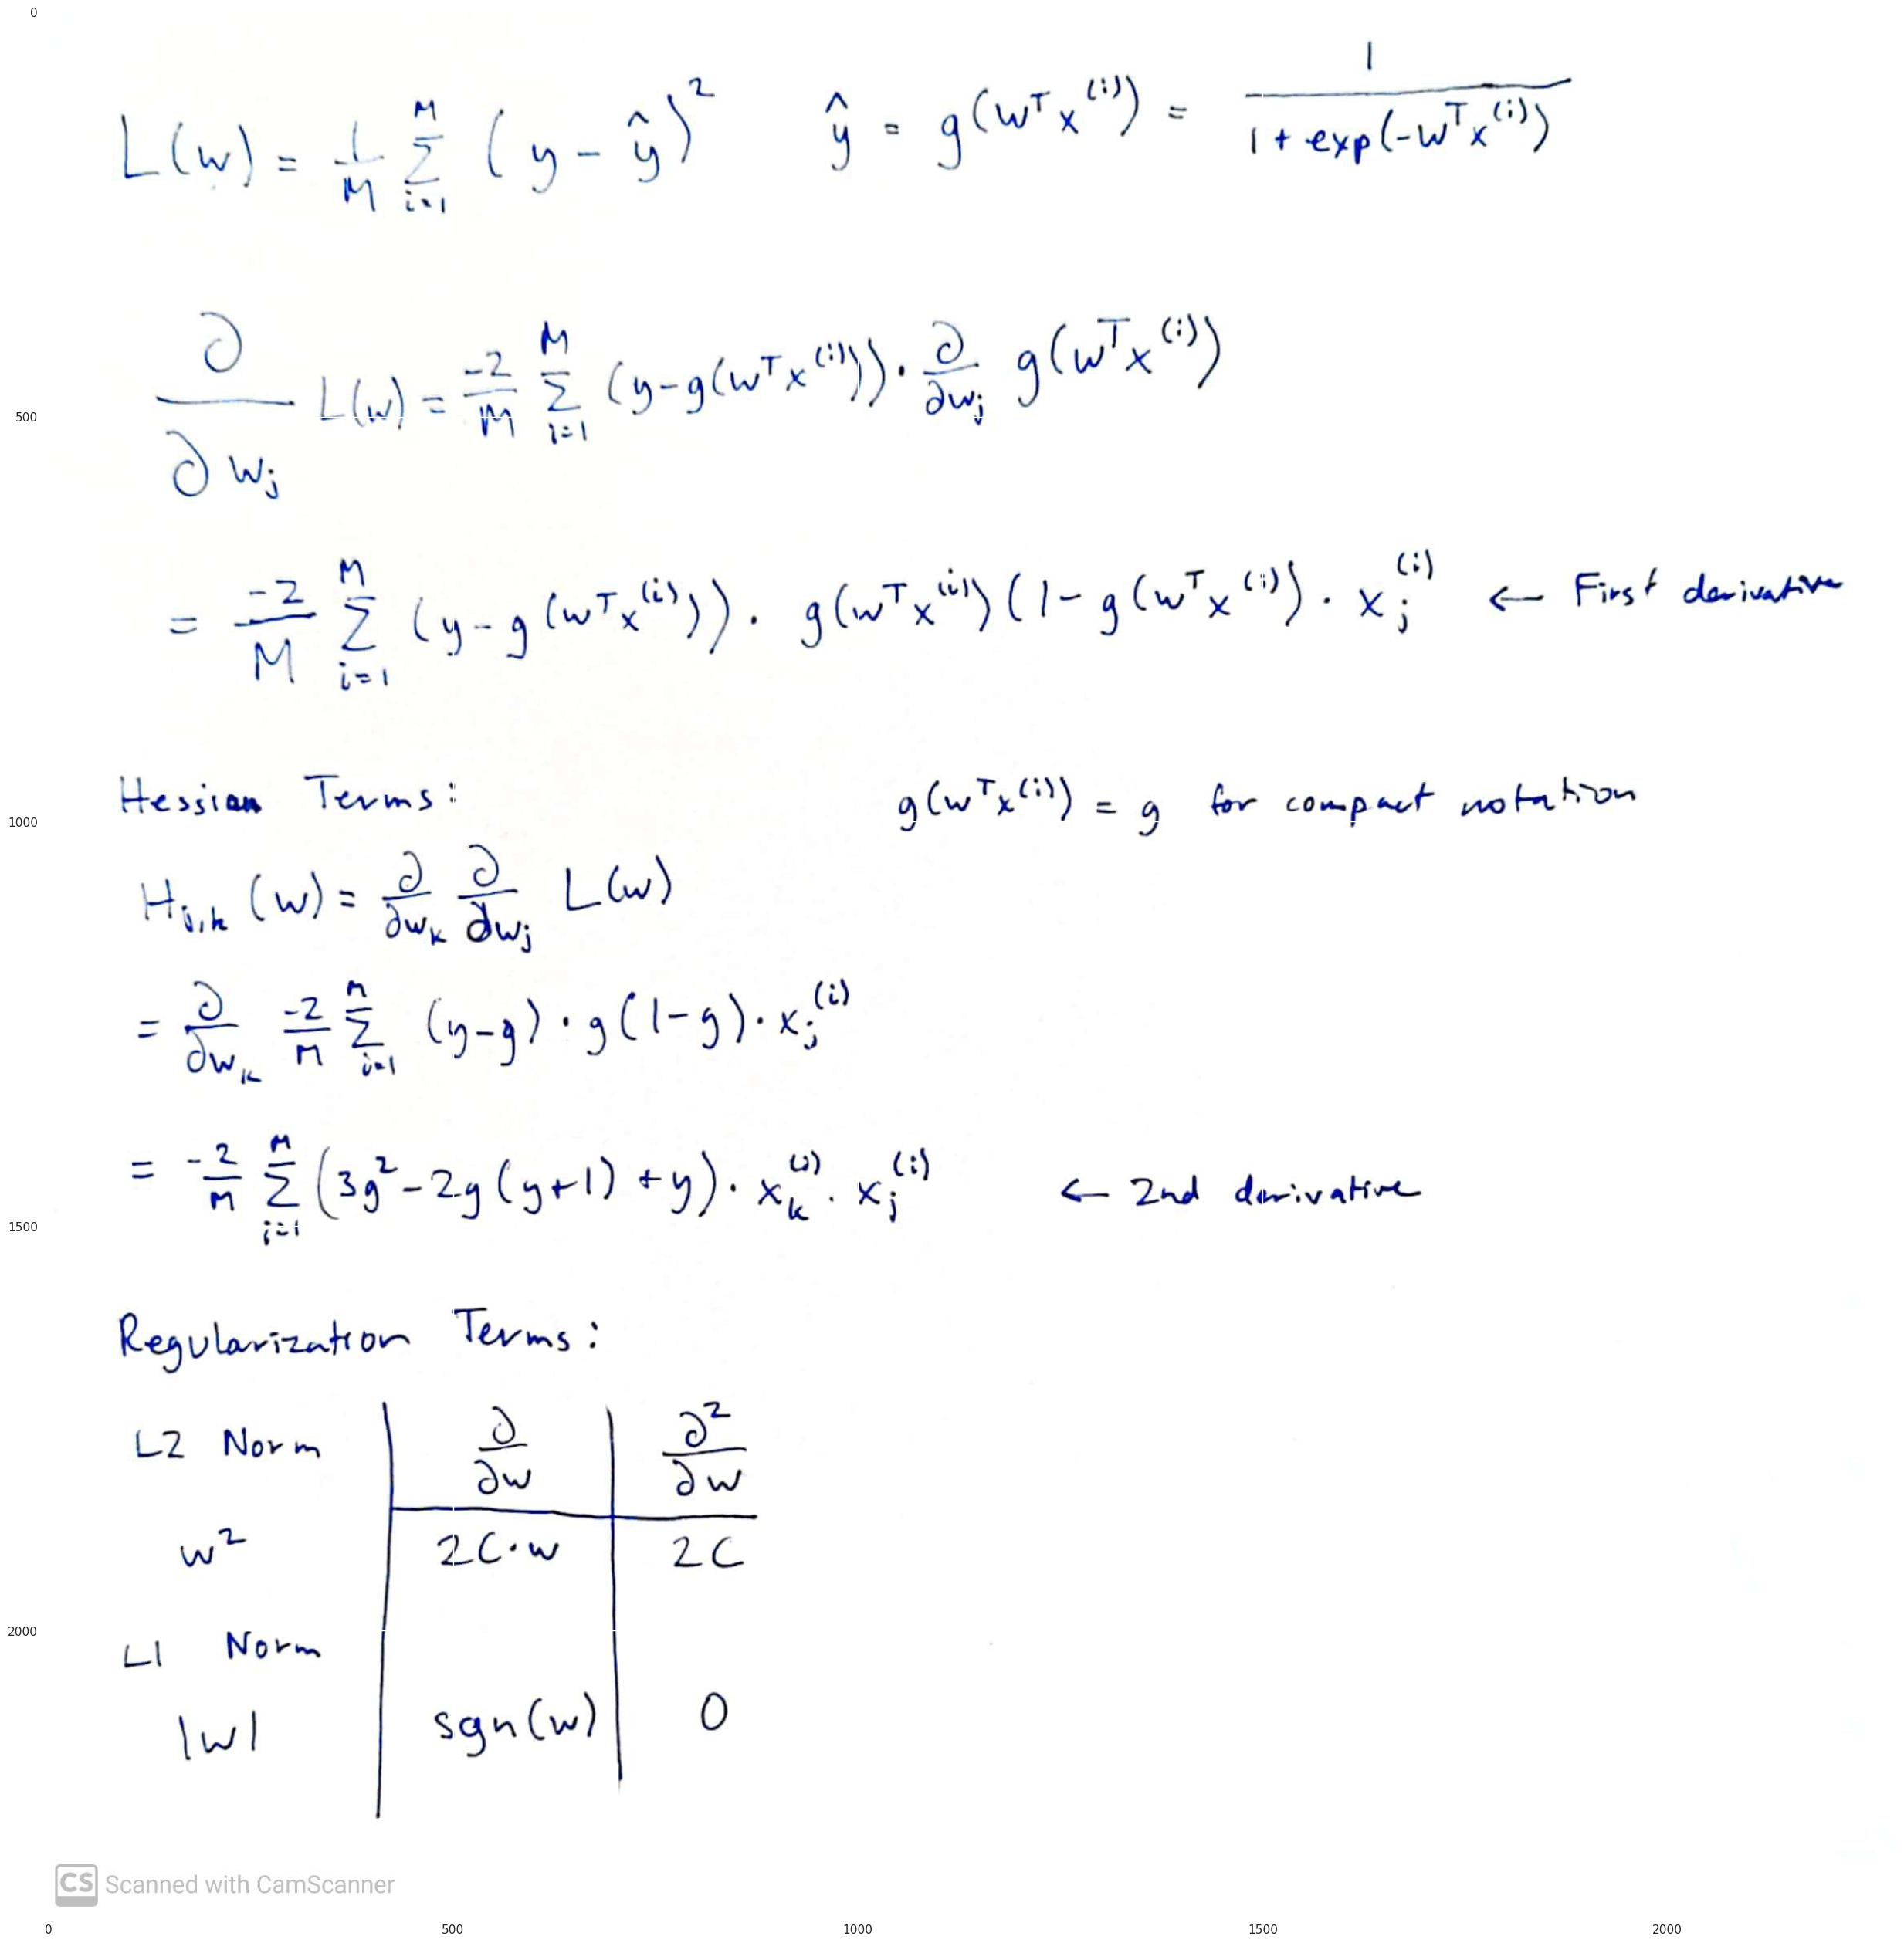

In [58]:
plt.figure(figsize=(32,32))
plt.imshow(plt.imread("graphics/derivations.jpg"))
plt.show() #this is just a workaround for embedding the image so the file doesn't have to be local to display

See section 2.1 for the implementation

I would prefer maximum likelihood estimation over mean squared error for a few reasons. First, I think the derivatives of MLE are more intuitive to calculate and implement than MSE. Also, performance-wise, Newton's method had consistently better F1 scores (shown in the table in section 2.2). While MLE is not guaranteed to always outperform MSE, the objective function space is guaranteed to be convex in MLE, and nonconvex in MSE [1]. This means that a classifier will be able to optimize its weights very close to the global optimum of the objective function for MLE, but the gradient ascent method could get stuck at a local optimum in MSE. The difference in performance this creates between the two is dataset dependent, but in general, this is a good reason to stick with MLE as the objective function.

I used this source to help derive the partial derivatives (the implementation I wrote myself)

[1] https://towardsdatascience.com/why-not-mse-as-a-loss-function-for-logistic-regression-589816b5e03c